# Session 11: Regression and regularization
In this combined teaching module and exercise set you will learn about linear regression models. We will see how overfitting can arise and how we can tackle it with a modification of the linear regression model.

We import our standard stuff. Notice that we are not interested in seeing the convergence warning in scikit-learn so we suppress them for now.

In [317]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns

%matplotlib inline

# Essential machine learning concepts

We start out slowly reviewing some of the concepts and providing an outline of this teaching module.

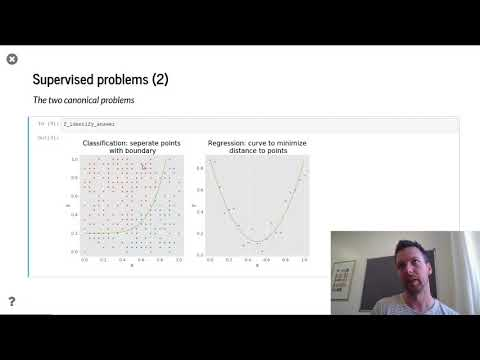

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('g3-UquXJRcY', width=640, height=360)

Before we proceed with some model details I just want to highlight a fundamental fact about (most) machine learning models. They are predictive models, with little or no attention to causality. See the discussion in the video below.

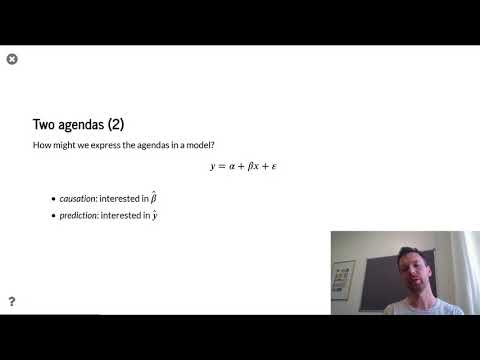

In [3]:
YouTubeVideo('yh_JKN8iigg', width=640, height=360)

The main use for machine learning was to balance out the over- and underfitting. Before we can do that we need a solid intuition about where the problems stem from and how they might look like. The video below visualizes the two problems and shows in the context of regression and classification problems.

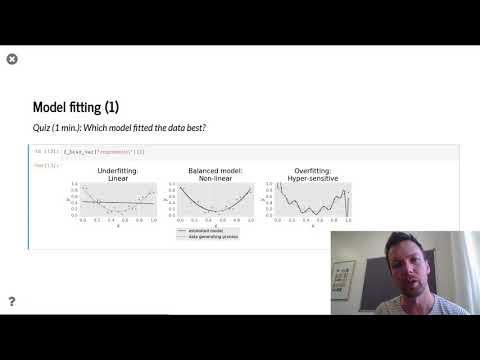

In [4]:
YouTubeVideo('ehLqyBqS5pc', width=640, height=360)

# Linear regression mechanics
### Implementing and evaluating the gradient decent 
 
Normally we use OLS to estimate linear regression models, but this is only way of solving the problem of minimizing the least squares problem (that minimizes the sum of squared errors). In the video below we show how to implement gradient descent below and compare it along with other approximate solutions to OLS.

You may find PML pp. 310-312, 319-324 useful as background reading.

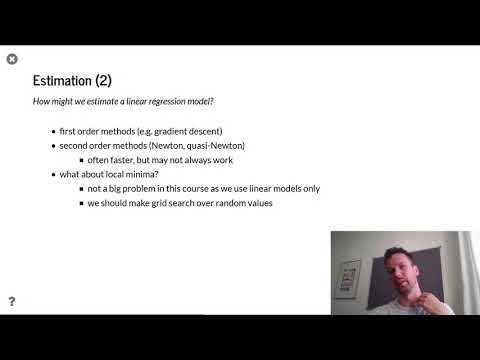

In [5]:
YouTubeVideo('d9Tn-lnU7Ds', width=640, height=360)

We continue straight to an exercise where you are to implement a new estimator that we code up from scratch. We solve the numerical optimization using the gradient decent algorithm. Using our algorithm we will fit it to some data, and compare our own solution to the standard solution from `sklearn`

> **Ex. 11.1.0**: Import the dataset `tips` from the `seaborn`.


*Hint*: use the `load_dataset` method in seaborn

In [319]:
tips = sns.load_dataset("tips")

> **Ex. 11.1.1**: Convert non-numeric variables to dummy variables for each category (remember to leave one column out for each catagorical variable, so you have a reference). Restructure the data so we get a dataset `y` containing the variable tip, and a dataset `X` containing the 
features. 

>> *Hint*: You might want to use the `get_dummies` method in pandas, with the `drop_first = True` parameter. 

In [320]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [326]:
tips_d = pd.get_dummies(tips, drop_first = True)
y = tips_d['tip']
X = tips_d.drop('tip', axis = 1)

> **Ex. 11.1.2**: Divide the features and target into test and train data. Make the split 50 pct. of each. The split data should be called `X_train`, `X_test`, `y_train`, `y_test`.

>> *Hint*: You may use `train_test_split` in `sklearn.model_selection`.

In [327]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.5)

In [328]:
X_train

,total_bill,size,sex_Female,smoker_No,day_Fri,day_Sat,day_Sun,time_Dinner
217,11.59,2,0,0,0,1,0,1
156,48.17,6,0,1,0,0,1,1
111,7.25,1,1,1,0,1,0,1
54,25.56,4,0,1,0,0,1,1
137,14.15,2,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...
33,20.69,4,1,1,0,1,0,1
203,16.40,2,1,0,0,0,0,0
44,30.40,4,0,1,0,0,1,1
162,16.21,3,1,1,0,0,1,1


> **Ex. 11.1.3**: Normalize your features by converting to zero mean and one std. deviation.

>> *Hint 1*: Take a look at `StandardScaler` in `sklearn.preprocessing`. 

>> *Hint 2*: If in doubt about which distribution to scale, you may read [this post](https://stats.stackexchange.com/questions/174823/how-to-apply-standardization-normalization-to-train-and-testset-if-prediction-i).

In [329]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
norm_scaler = StandardScaler().fit(X_train) 
X_train = norm_scaler.transform(X_train) 
X_test = norm_scaler.transform(X_test) 

> **Ex. 11.1.4**: Make a function called `compute_error` to compute the prediction errors given input target `y_`, input features `X_` and input weights `w_`. You should use matrix multiplication.
>
>> *Hint 1:* You can use the net-input fct. from yesterday.
>>
>> *Hint 2:* If you run the following code,
>> ```python
y__ = np.array([1,1])
X__ = np.array([[1,0],[0,1]])
w__ = np.array([0,1,1])
compute_error(y__, X__, w__)
```

>> then you should get output:
```python 
array([0,0])
```



In [333]:
w = np.zeros(1+X.shape[1])

def net_input(X, w):    
    return np.dot(X, w[1:]) + w[0]

def compute_error(y, X, w):
    return y - net_input(X, w)

> **Ex. 11.1.5**: Make a function to update the weights given input target `y_`, input features `X_` and input weights `w_` as well as learning rate, $\eta$, i.e. greek `eta`. You should use matrix multiplication.

In [335]:
def f(y,x, w, eta):
    errors = compute_error(y,x,w)
    w[1:] = w[1:] + eta * x.T.dot(errors)
    w[0] = w[0] +eta * errors.sum() 
    return w

In [336]:
def f(y,x, w, eta):
    for xi,yi in zip(x,y):
        update = eta * (yi - net_input(xi, w))
        w[1:] = w[1:] + update * xi
        w[0] = w[0] + update
    return w

> **Ex. 11.1.6**: Use the code below to initialize weights `w` at zero given feature set `X`. Notice how we include an extra weight that includes the bias term. Set the learning rate `eta` to 0.001. Make a loop with 50 iterations where you iteratively apply your weight updating function. 

>```python
w = np.zeros(1+X.shape[1])
```

In [337]:
w = np.zeros(1+X.shape[1])
eta = 0.001
for i in range(50):
    print(f(y_train,X_train,w,eta))

[ 0.32451247  0.07459608  0.0641979  -0.01034049 -0.00134893 -0.00768194
  0.00171892  0.01796439  0.02273364]
[ 0.61163096  0.13541984  0.11507152 -0.01672154 -0.00426254 -0.0119825
  0.0027414   0.03082404  0.03939007]
[ 0.86565822  0.18519793  0.15537455 -0.020222   -0.00810015 -0.01392859
  0.00323109  0.03995664  0.05150974]
[ 1.09040341  0.22609532  0.18727897 -0.02165278 -0.01241162 -0.01427307
  0.0033198   0.04638509  0.06025601]
[ 1.28923841  0.25983436  0.21250076 -0.02162109 -0.01688661 -0.01356353
  0.00311283  0.0508659   0.06650531]
[ 1.46514769  0.2877881   0.23239792 -0.02057959 -0.02131662 -0.01219433
  0.00269367  0.05395611  0.07091615]
[ 1.62077261  0.31105341  0.24804698 -0.01886378 -0.02556677 -0.01044606
  0.00212793  0.05606373  0.07398174]
[ 1.75845072e+00  3.30508447e-01  2.60302862e-01 -1.67206381e-02
 -2.95548255e-02 -8.51512868e-03  1.46666624e-03  5.74858124e-02
  7.60701547e-02]
[ 1.88025058e+00  3.46857814e-01  2.69845691e-01 -1.43303220e-02
 -3.3235729

> **Ex. 11.1.7**: Make a function to compute the mean squared error. Alter the loop so it makes 100 iterations and computes the MSE for test and train after each iteration, plot these in one figure. 

>> Hint: You can use the following code to check that your model works:
>>```python
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train, y_train)
assert((w[1:] - reg.coef_).sum() < 0.01)
```

In [338]:
def MSE(y_, X_, w_):
    error_squared = compute_error(y_, X_, w_)**2
    return error_squared.sum() / len(y_)

In [341]:
w = np.zeros(X.shape[1]+1)

MSE_train = [MSE(y_train, X_train, w)]
MSE_test = [MSE(y_test, X_test, w)]

for i in range(100):
    f(y_train, X_train, w, eta)
    
    MSE_train.append(MSE(y_train, X_train, w))
    MSE_test.append(MSE(y_test, X_test, w))    

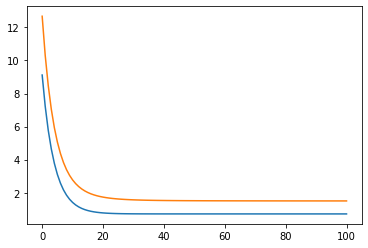

In [342]:
pd.Series(MSE_train).plot()
pd.Series(MSE_test).plot()

In [343]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train, y_train)
assert((w[1:] - reg.coef_).sum() < 0.01)

The following bonus exercises are for those who have completed all other exercises until now and have a deep motivation for learning more.

> **Ex. 11.1.8 (BONUS)**: Implement your linear regression model as a class.

# Overfitting in linear regression 
### Exploring overfitting in linear regression
How does overfitting manifest itself in linear regression? In the video below we simulate what happens as make a better and better taylor approximation, i.e. we estimate a polynomial of higher and higher order. Two issues arise simultaneously - one is related to the number of parameters and the to the size of the parameters. 

In [ ]:
YouTubeVideo('GDTSKQMzyF0', width=640, height=360)


### A cure for overfitting in linear regression

How do we fix the two issues of excessively large weights/coefficients and too many spurious solutions? The video below provides a solution by directly incorporating these issues into the optimization problem.

You may find PML pp. 73-76, 123-136, 332-334 useful as background reading.

In [ ]:
YouTubeVideo('wfqV3l6y92E', width=640, height=360)

Above we tackled overfitting, but what about ***underfitting***? The video below shows how to address underfitting and also zooms in on some important details about regularization.

You may find PML pp. 120-123 useful as background reading.

In [ ]:
YouTubeVideo('Zih-j7FMU0Y', width=640, height=360)

> **Ex. 11.1.9 (BONUS)**: Is it possible to adjust our linear model to become a Lasso? Is there a simple fix?

## Modelling houseprices
In this example we will try to predict houseprices using a lot of variable (or features as they are called in Machine Learning). We are going to work with Kaggle's dataset on house prices, see information [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). Kaggle is an organization that hosts competitions in building predictive models.

> **Ex. 11.2.0:** Load the california housing data with scikit-learn using the code below. Inspect the data set. 

In [4]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

cal_house = fetch_california_housing()    
X = pd.DataFrame(data=cal_house['data'], 
                 columns=cal_house['feature_names'])\
             .iloc[:,:-2]
y = cal_house['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=1)

X.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333




> **Ex.11.2.1**: Generate interactions between all features to third degree, make sure you **exclude** the bias/intercept term. How many variables are there? Will OLS fail? 

> After making interactions rescale the features to have zero mean, unit std. deviation. Should you use the distribution of the training data to rescale the test data?  

>> *Hint 1*: Try importing `PolynomialFeatures` from `sklearn.preprocessing`

>> *Hint 2*: If in doubt about which distribution to scale, you may read [this post](https://stats.stackexchange.com/questions/174823/how-to-apply-standardization-normalization-to-train-and-testset-if-prediction-i).

In [48]:
# [Answer to Ex. 11.2.1]

> **Ex.11.2.2**: Estimate the Lasso model on the rescaled train data set, using values of $\lambda$ in the range from $10^{-4}$ to $10^4$. For each $\lambda$  calculate and save the Root Mean Squared Error (RMSE) for the rescaled test and train data. 

> *Hint*: use `logspace` in numpy to create the range.


In [34]:
# [Answer to Ex. 11.2.2]

> **Ex.11.2.3**: Make a plot with on the x-axis and the RMSE measures on the y-axis. What happens to RMSE for train and test data as $\lambda$ increases? The x-axis should be log scaled. Which one are we interested in minimizing? 

> Bonus: Can you find the lambda that gives the lowest MSE-test score?

In [36]:
# [Answer to Ex. 11.2.3]